In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import torch
import shap

from typing import List

import pickle as pkl
import matplotlib.gridspec as gridspec
from dataset import Dataset
from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics
from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)
module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_feature_values(feature_values, x_test, feature_names):

    feature_num = feature_values.shape[1]
    ind = np.argpartition(np.abs(feature_values).mean(0), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(np.array(feature_names)[ind], np.abs(feature_values[:, ind]).mean(0).round(4))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        show=False
    )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('CRASH-2 - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.1, -2.5, "Intensive Tx worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.1, -2.5, "Intensive Tx better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)

    plt.show()

In [152]:
blood_pressure = pd.read_csv("data/accord/bloodpressure.csv")
accord_key = pd.read_csv("data/accord/accord_key.csv")
meds = pd.read_csv("data/accord/concomitantmeds.csv")
labs = pd.read_csv("data/accord/otherlabs.csv")
lipids = pd.read_csv("data/accord/lipids.csv")
hba1c = pd.read_csv("data/accord/hba1c.csv")
cvdoutcomes = pd.read_csv("data/accord/cvdoutcomes.csv")
activity = pd.read_csv("data/accord/activitystatus.csv")
history = pd.read_csv("data/accord/inclusionexclusionsummary.csv")
pe = pd.read_csv("data/accord/baselinehistoryphysicalexam.csv")

In [153]:
## Preprocessing medications 

pe["bmi"] = pe["wt_kg"]/((pe["ht_cm"]/100)**2)

meds.rename(columns={"potassium":"potassium_oral"}, inplace=True)
dm_meds = [
       'la_insulin', 'othbol_insulin', 'premix_insulin', 'other_diabmed',
       'nphl_insulin', 'meglitinide', 'ag_inhibitor', 'reg_insulin',  'tzd'
        , 'sulfonylurea', 'biguanide'
]

bp_meds = [
        'a2rb', 'acei', 'dhp_ccb', 'nondhp_ccb', 'alpha_blocker', 'central_agent',
        'beta_blocker', 'vasodilator', 'reserpine', 'other_bpmed',
]

cv_meds = [
        'digitalis', 'nitrate', 'other_cvmed',  
]

lipid_meds = [
        'fibrate', 'other_lipidmed', 'cholest_abi'
]

# TBD
# 'loop', 'thiazide', 'ksparing', 'potassium_oral', 
# 'anti_inflam','bile_sequestrant',
# 'cox2', 'thyroid', 'progestin', 'estrogen', 'oral_asthma',
# 'anti_depress', 'inhaled_asthma', 'oral_steroid', 'anti_psych',
# 'osteoporosis', 'fluid_retention', 'other_med', 'vitamin', 'otc',
# 'herbal'

totalmeds = [
            'a2rb', 'acei', 'dhp_ccb', 'nondhp_ccb', 'alpha_blocker', 'central_agent',
        'beta_blocker', 'vasodilator', 'reserpine', 'other_bpmed',
            'digitalis', 'nitrate', 'other_cvmed',  
        'fibrate', 'other_lipidmed', 'cholest_abi',
       'la_insulin', 'othbol_insulin', 'premix_insulin', 'other_diabmed',
       'nphl_insulin', 'meglitinide', 'ag_inhibitor', 'reg_insulin',  'tzd'
        , 'sulfonylurea', 'biguanide',
            'loop', 'thiazide', 'ksparing', 'potassium_oral', 
        'anti_inflam','bile_sequestrant',
        'cox2', 'thyroid', 'progestin', 'estrogen', 'oral_asthma',
        'anti_depress', 'inhaled_asthma', 'oral_steroid', 'anti_psych',
        'osteoporosis', 'other_med', 
     # 'fluid_retention',
    # 'vitamin', 'otc',
        # 'herbal'
]

# Create new columns based on the presence of medications in the categories
meds['dm_med'] = meds[dm_meds].sum(axis=1)
meds['bp_med'] = meds[bp_meds].sum(axis=1)
meds['cv_med'] = meds[cv_meds].sum(axis=1)
meds['lipid_med'] = meds[lipid_meds].sum(axis=1)
# meds["nagents"] = meds[totalmeds].sum(axis=1)


(array([ 2456.,     0.,  6760.,     0.,     0., 14935.,     0., 16656.,
            0.,     0., 12353.,     0.,  5687.,     0.,     0.,  1476.,
            0.,   209.,     0.,    28.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
        5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]),
 <BarContainer object of 20 artists>)

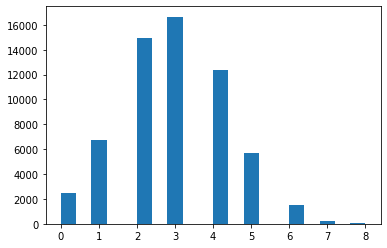

In [154]:
plt.hist(meds["dm_med"], bins=20)

In [155]:

dfs = [
    cvdoutcomes[["MaskID", "censor_po"]],
    history[["MaskID","x4smoke"]],
    pe[["MaskID", "bmi"]],
    accord_key[accord_key.treatment.str.contains("BP")][["MaskID", "female", "baseline_age", "treatment", "cvd_hx_baseline", "raceclass"]],
    lipids[lipids.Visit == "BLR"].drop(columns="Visit"),
    labs[labs.Visit == "BLR"].drop(columns="Visit"),
    blood_pressure[blood_pressure.Visit == "BLR"].drop(columns="Visit"),
    meds[meds.Visit == "BLR"].drop(columns="Visit")
]

# Merge all dataframes using reduce
data = reduce(lambda left, right: pd.merge(left, right, on="MaskID", how="inner"), dfs)

data.to_csv("accord.csv")

In [237]:
outcome = "censor_po"
treatment = "treatment"

continuous_vars = [
    'baseline_age', 
    'bmi',
    'sbp', 'dbp','hr',
    'fpg', 'alt', 'cpk',
    'potassium', 'screat', 'gfr',
    'ualb', 'ucreat', 'uacr',
    'chol', 'trig','vldl', 'ldl','hdl'

]


binary_vars = [
    'female',
    'cvd_hx_baseline',
    # 'cvdhist',
    'statin',
    'aspirin',
    'antiarrhythmic',
    'anti_coag',
    'dm_med',
    'bp_med',
    'cv_med',
    'lipid_med',
    'x4smoke'
]

cate_vars = [
    # 'raceclass'
]

data["raceclass"] = np.where(data["raceclass"]=="Black", 1, 0)
data["treatment"] = np.where(data["treatment"].str.contains("Intensive BP"), 1, 0)
# data["censor_po"] = np.where(data["censor_po"]==1, 0, 1)


data = data[continuous_vars + cate_vars + binary_vars + [treatment] + [outcome]]

scaler = preprocessing.MinMaxScaler()
data[continuous_vars] = scaler.fit_transform(data[continuous_vars])
data = pd.get_dummies(data, columns=cate_vars)
names = data.drop([treatment, outcome], axis=1).columns 
print(names)

Index(['baseline_age', 'bmi', 'sbp', 'dbp', 'hr', 'fpg', 'alt', 'cpk',
       'potassium', 'screat', 'gfr', 'ualb', 'ucreat', 'uacr', 'chol', 'trig',
       'vldl', 'ldl', 'hdl', 'female', 'cvd_hx_baseline', 'statin', 'aspirin',
       'antiarrhythmic', 'anti_coag', 'dm_med', 'bp_med', 'cv_med',
       'lipid_med', 'x4smoke', 'raceclass_Black', 'raceclass_Hispanic',
       'raceclass_Other', 'raceclass_White'],
      dtype='object')


In [103]:
pd.read_csv("data/accord/accord.csv")

,Unnamed: 0,MaskID,censor_po,x4smoke,bmi,female,baseline_age,treatment,cvd_hx_baseline,raceclass,...,osteoporosis,fluid_retention,other_med,vitamin,otc,herbal,dm_med,bp_med,cv_med,lipid_med
0,0,100001,1,2,35.912177,0,60.8,Standard Gylcemia/Intensive BP,0,White,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
1,1,100006,1,2,41.937257,1,56.7,Intensive Gylcemia/Intensive BP,0,White,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,2,100016,1,2,33.220108,0,65.6,Intensive Gylcemia/Intensive BP,1,White,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0
3,3,100017,1,2,27.493591,0,69.7,Standard Gylcemia/Intensive BP,0,Black,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0
4,4,100026,1,2,34.167942,0,56.2,Intensive Gylcemia/Intensive BP,0,White,...,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,4707,110243,1,2,36.134164,0,57.0,Standard Gylcemia/Standard BP,1,White,...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0
4708,4708,110247,1,2,42.613394,0,62.8,Standard Gylcemia/Intensive BP,0,Black,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0
4709,4709,110248,1,2,33.519700,0,64.9,Intensive Gylcemia/Standard BP,1,Black,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4710,4710,110250,1,2,34.982000,0,60.9,Intensive Gylcemia/Intensive BP,0,Black,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0


In [97]:
data = Dataset("accord", 0)


In [74]:
data = Dataset("accord", 0)

x, w, y = data.get_data()

trials = 15

results = np.zeros((trials, len(x)))

# for i in range(trials):
    
model = pseudo_outcome_nets.XLearner(  
    x.shape[1],
    binary_y=(len(np.unique(y)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1000,
    nonlin="relu",
    device="cpu",
    # seed= i
)

model.fit(x, y, w)
    # results[i] = model.predict(x).detach().cpu().numpy().reshape(-1)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.8648150563240051, train_loss: 0.8878701329231262
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.3794481158256531, train_loss: 0.35048165917396545
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.3032885491847992, train_loss: 0.2599993050098419
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.289209246635437, train_loss: 0.21974289417266846
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.2887701988220215, train_loss: 0.20792840421199799
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6362477540969849, train_loss: 0.6520913243293762
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.3297097682952881, train_loss: 0.27457091212272644
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.29769301414489746, train_loss: 0.1954454630613327
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.2958894

XLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=31, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=31, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimato

0.014835724539467602 (30, 4712)
Output 0.014835724539467602: 95% CI = (0.001, 0.026)


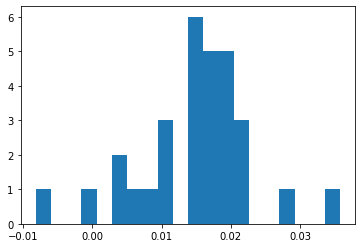

In [3]:
import pickle as pkl

predict_results  = pkl.load(open("results/accord/predict_results.pkl", 'rb'))

mean_ates = predict_results.mean(1)

print(mean_ates.mean(0), predict_results.shape)
plt.hist(mean_ates, bins=20)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

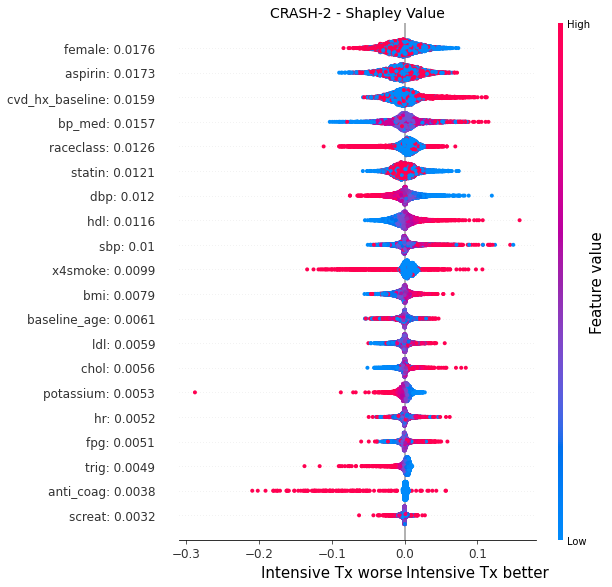

Index(['baseline_age', 'bmi', 'sbp', 'dbp', 'hr', 'fpg', 'alt', 'cpk',
       'potassium', 'screat', 'gfr', 'uacr', 'chol', 'trig', 'vldl', 'ldl',
       'hdl', 'female', 'raceclass', 'cvd_hx_baseline', 'statin', 'aspirin',
       'antiarrhythmic', 'anti_coag', 'bp_med', 'x4smoke'],
      dtype='object')

In [3]:
data = Dataset("accord", 0 )

x, w , y = data.get_data()

gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/accord/shap_bootstrapped.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

data.get_feature_names()

(array([4165.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         547.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

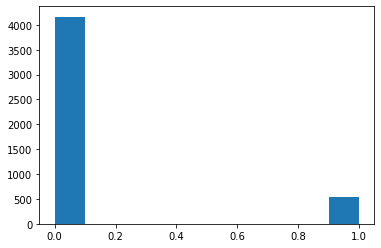

In [4]:
plt.hist(x[:, -1])

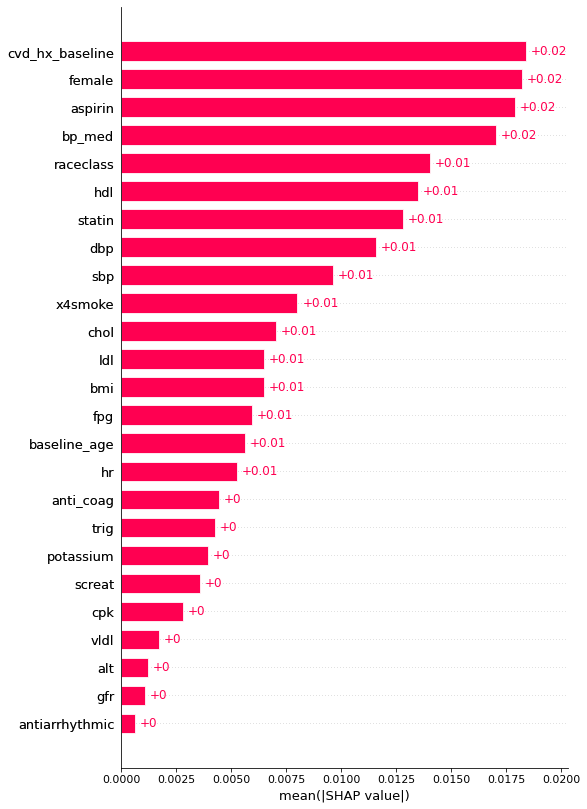

In [8]:
exp = shap.Explanation(
    avg_shap.mean(0),  
    feature_names = data.get_feature_names()
)

shap.plots.bar(
    exp,
    max_display=len(data.get_feature_names()),
)


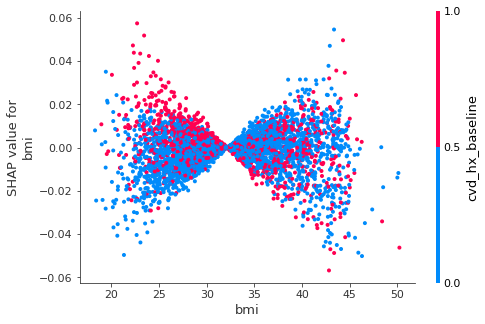

In [60]:
x_raw_con = data.get_unnorm_value(x)

x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)

shap.dependence_plot(
    "bmi", 
     avg_shap.mean(0), 
     x_raw, 
     feature_names=data.get_feature_names(),
     interaction_index="cvd_hx_baseline"
)

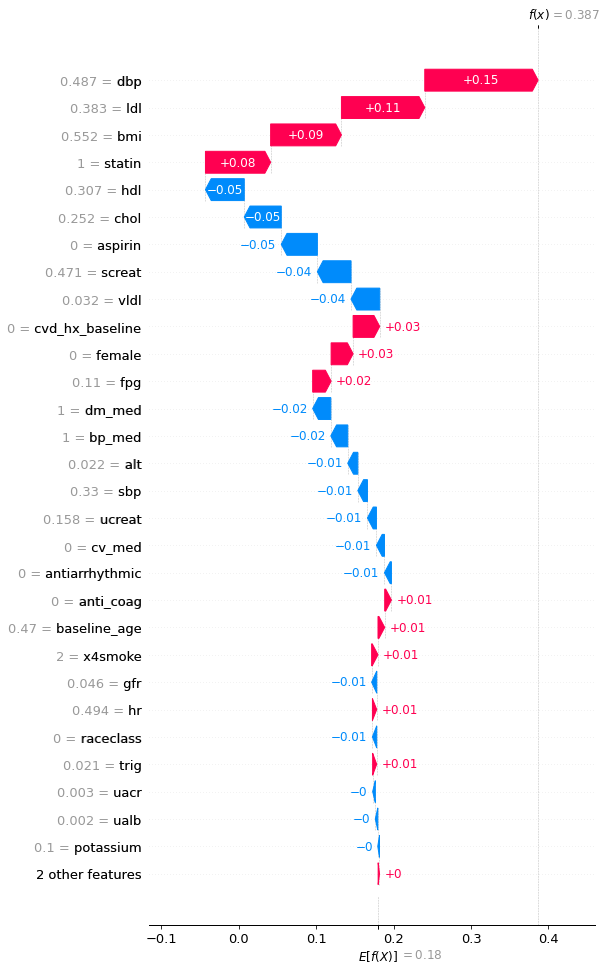

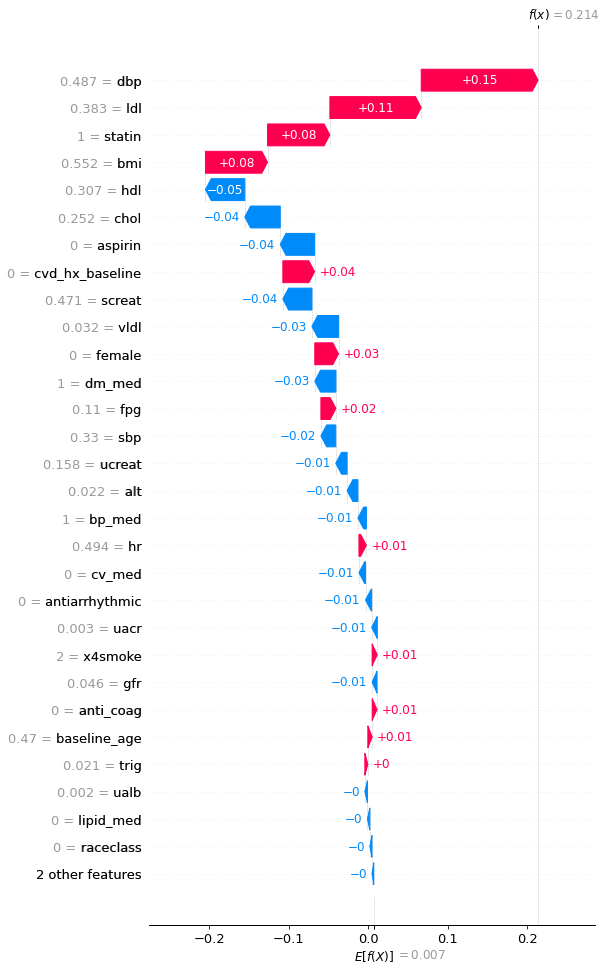

In [111]:
from shap import Explanation

import matplotlib.pyplot as plt
from PIL import Image

data = Dataset("accord", 0)

baseline_output = model.predict(x.mean(0).reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    marginal_shapley_value[1].reshape(1, -1),  
    baseline_output[0],
    data=data.get_data()[0],
    feature_names=data.get_feature_names(),
)

shap.plots.waterfall(exp[0], max_display=baseline.shape[1]) 


plt.savefig('temp_plot1.png', bbox_inches='tight')
plt.close()

baseline_output = model.predict(sprint_means.reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    sprint_shap[1].reshape(1, -1),  
    baseline_output[0],
    data=data.get_data()[0],
    feature_names=data.get_feature_names(),
)


# Create the second shap plot and save as a temporary image
shap.plots.waterfall(exp[0], max_display=baseline.shape[1])
plt.savefig('temp_plot2.png', bbox_inches='tight')
plt.close()



In [108]:
baseline_output

array([[0.18008661]], dtype=float32)

In [106]:
baseline_output

array([[0.00712857]], dtype=float32)

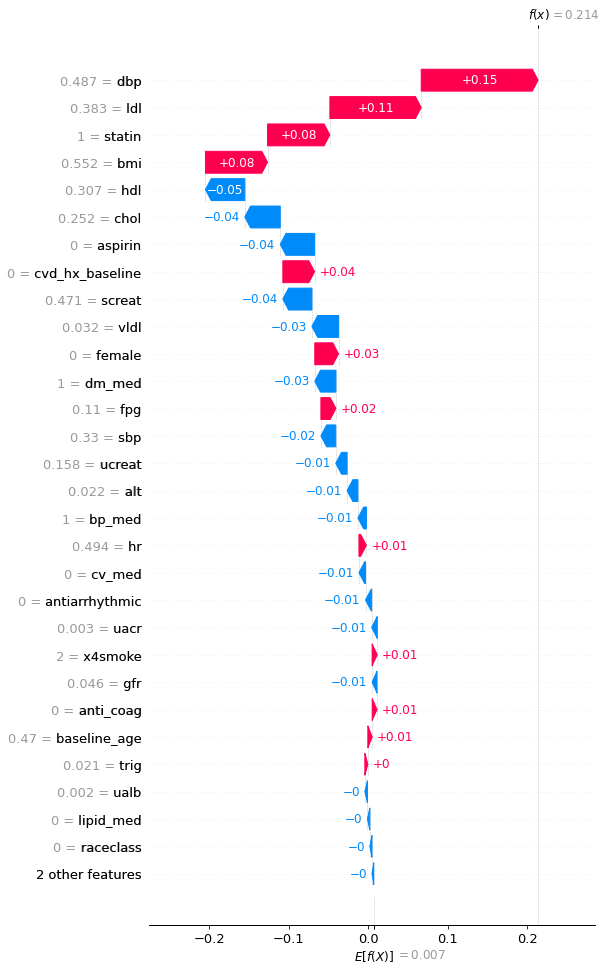

In [105]:
baseline_output = model.predict(sprint_means.reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    sprint_shap[1].reshape(1, -1),  
    baseline_output[0],
    data=data.get_data()[0],
    feature_names=data.get_feature_names(),
)

shap.plots.waterfall(exp[0], max_display=baseline.shape[1]) 

In [72]:
data = Dataset("sprint",0)

data.get_feature_names()

Index(['age', 'sbp', 'dbp', 'n_agents', 'egfr', 'screat', 'chr', 'glur', 'hdl',
       'trr', 'umalcr', 'bmi', 'female', 'race_black', 'smoke_3cat', 'aspirin',
       'statin', 'sub_cvd', 'sub_ckd'],
      dtype='object')

In [73]:
data.data

,age,sbp,dbp,n_agents,egfr,screat,chr,glur,hdl,trr,...,bmi,female,race_black,smoke_3cat,aspirin,statin,sub_cvd,sub_ckd,intensive,event_primary
0,0.285714,0.459119,0.425532,0.333333,0.309159,0.190608,0.228883,0.152893,0.131944,0.020802,...,0.346973,0,0,1,1.0,1.0,1,0,0,1
1,0.642857,0.415094,0.329787,0.166667,0.268058,0.207182,0.468665,0.260331,0.305556,0.049744,...,0.270478,0,0,0,1.0,1.0,0,0,0,1
2,0.190476,0.452830,0.468085,0.500000,0.410599,0.080110,0.438692,0.210744,0.250000,0.048236,...,0.199690,1,0,0,0.0,1.0,0,0,1,1
3,0.333333,0.446541,0.553191,0.333333,0.313531,0.185083,0.297003,0.297521,0.208333,0.030751,...,0.356424,0,0,0,0.0,0.0,0,0,1,1
4,0.642857,0.320755,0.297872,0.333333,0.333936,0.099448,0.444142,0.202479,0.500000,0.025927,...,0.279348,1,0,0,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9356,0.714286,0.415094,0.202128,0.333333,0.378418,0.080110,0.348774,0.190083,0.472222,0.015375,...,0.240833,1,0,0,1.0,1.0,0,0,0,1
9357,0.880952,0.295597,0.351064,0.500000,0.046289,0.458564,0.201635,0.161157,0.243056,0.021706,...,0.509474,1,0,0,0.0,1.0,0,1,0,1
9358,0.428571,0.408805,0.372340,0.000000,0.350259,0.160221,0.261580,0.148760,0.201389,0.015677,...,0.102543,0,0,0,0.0,1.0,1,0,0,1
9359,0.190476,0.515723,0.563830,0.000000,0.102956,0.337017,0.474114,0.243802,0.138889,0.104311,...,0.391090,1,0,0,1.0,0.0,0,1,1,1


In [71]:
x, w, y = data.get_data()

data.get_feature_range(3)

AttributeError: 'DataFrame' object has no attribute 'get_data'

# Create baseline from SPRINT

In [95]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_means_to_df2_scale(df2, df1):
    
    # Mapping of the second dataset columns to the first dataset columns
    
    mapping = {
        'baseline_age': 'age',
        'sbp': 'sbp',
        'dbp': 'dbp',
        'gfr': 'egfr',
        'screat': 'screat',
        'hdl': 'hdl',
        'bmi': 'bmi',
        'female': 'female',
        'raceclass': 'race_black',
        'x4smoke': 'smoke_3cat',
        'aspirin': 'aspirin',
        'statin': 'statin',
        'bp_med': 'n_agents'
    }

    # Columns that we won't normalize but will use their original mean
    columns_no_normalize = ['female', 'race_black', 'smoke_3cat', 'aspirin', 'statin']

    # Calculate means of df2's mapped columns
    
    df2_sampled = df2.sample(n=len(df2), replace=True)

    df2_means = df2_sampled[list(mapping.keys())].mean()

    normalized_means = []

    for key, value in mapping.items():
        mean_val = df2_means[key]
        if value not in columns_no_normalize:
            # Scale the mean value of df2's column using df1's column scale
            scaler = MinMaxScaler()
            # Fit the scaler to df1's column
            scaler.fit(df1[value].values.reshape(-1, 1))
            # Transform df2's mean value
            normalized_mean = scaler.transform([[mean_val]])[0][0]
        else:
            # If column is in columns_no_normalize list, just use the raw mean
            normalized_mean = mean_val

        normalized_means.append(normalized_mean)

    # Convert to numpy array
    result_array = pd.Series(normalized_means, index=list(mapping.values())).reindex(df1.columns, fill_value=np.nan).to_numpy()
    return result_array


data = pd.read_csv("data/accord/accord.csv")

continuous_vars = [
    'baseline_age', 
    'bmi',
    'sbp', 
    'dbp',
    'hr',
    'fpg', 
    'alt', 
    'cpk',
    'potassium',
    'screat', 
    'gfr',
    'ualb', 
    'ucreat', 'uacr',
    'chol', 'trig','vldl', 'ldl','hdl'
]

binary_vars = [
    'female',
    'raceclass',
    'cvd_hx_baseline',
    'statin',
    'aspirin',
    'antiarrhythmic',
    'anti_coag',
    'dm_med',
    'bp_med',
    'cv_med',
    'lipid_med',
    'x4smoke'
]
data["raceclass"] = np.where(data["raceclass"]== "Black", 1, 0)

data2 = data[continuous_vars+ binary_vars]

outcome = pd.read_csv("data/sprint/outcomes.csv")
baseline = pd.read_csv("data/sprint/baseline.csv")

baseline.columns = [x.lower() for x in baseline.columns]
outcome.columns = [x.lower() for x in outcome.columns]

data = baseline.merge(outcome, on="maskid", how="inner")

data["smoke_3cat"] = np.where(data["smoke_3cat"] == 4, np.nan,data["smoke_3cat"] )
data["smoke_3cat"] = np.where(data["smoke_3cat"] == 3, 1, 0 )        

continuous_vars = [
    "age", 
    "sbp",
    "dbp",
    "n_agents",
    "egfr", 
    "screat",
    "chr",
    "glur",
    "hdl",
    "trr",
    "umalcr",
    "bmi",
    # "risk10yrs"
]

binary_vars = [
    "female" ,
    "race_black",
    "smoke_3cat",
    "aspirin",
    "statin",
    "sub_cvd",
    "sub_ckd"
    # "inclusionfrs"
    # "noagents"
]


data1 = data[continuous_vars+binary_vars]

accord_means = normalize_means_to_df2_scale(data2, data1)


In [96]:
# sprint_means[np.isnan(sprint_means)] = x.mean(0)[np.isnan(sprint_means)]
accord_means


array([0.35079129, 0.42246612, 0.38118611, 0.21289615, 0.45009597,
       0.13191663,        nan,        nan, 0.20170575,        nan,
              nan, 0.32764209, 0.46434635, 0.22347199, 1.87351443,
       0.51680851, 0.65191489,        nan,        nan])

In [77]:
data = Dataset("sprint",0)
len(data.get_feature_names())

19

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

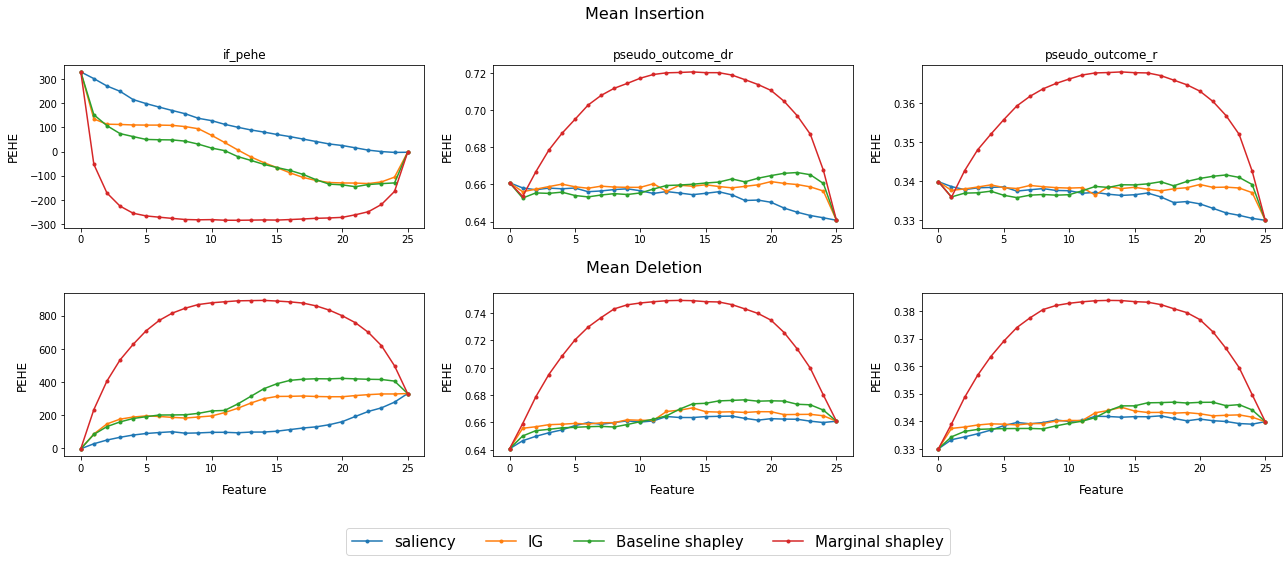

In [61]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"results/accord/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])
            auroc_ate[exp].append(results[exp_index][4])
            
            auroc_full.append(results[exp_index][7])
            auroc_full_ate.append(results[exp_index][6])
            
            auroc_random.append(results[exp_index][9])
            auroc_random_ate.append(results[exp_index][8])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


0.009703022500743036 saliency
0.01604778415198544 integrated_gradients
0.014597389933160355 baseline_shapley_value_sampling
0.02297112534685832 marginal_shapley_value_sampling
0.513110289826331 saliency
0.5552921137660812 integrated_gradients
0.5402220178162295 baseline_shapley_value_sampling
0.5880636226676595 marginal_shapley_value_sampling


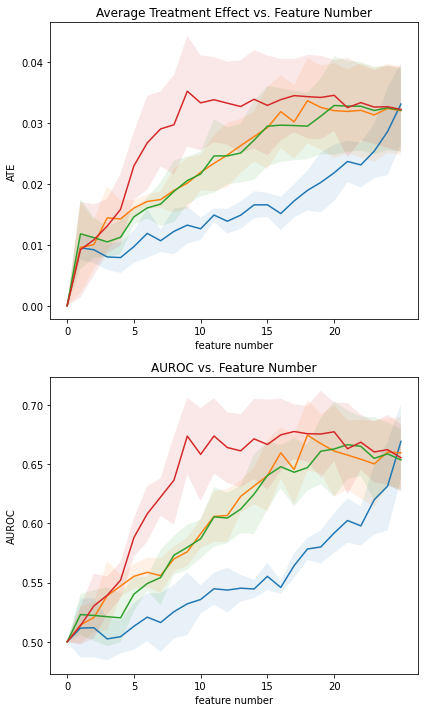

In [63]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))


# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)

    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    print(v[4], k)

    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, x.shape[1], 5))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    
    print(v[4], k)

    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, x.shape[1], 5))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.95, 0.1))

plt.tight_layout()
plt.show()